<a href="https://colab.research.google.com/github/sidagarwal-labs/DSBA-6211---Advance-Business-Analytics/blob/main/Time_Series_Wine_Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import the dataset and view
import pandas as pd
import numpy as np
dfSA = pd.read_csv("AustralianWines.csv")

In [ ]:
dfSA.describe(include='all')

,Month,Red
count,180,180.000000
unique,180,NaN
top,1/1/1980,NaN
freq,1,NaN
mean,NaN,1629.727778
std,NaN,614.933333
min,NaN,464.000000
25%,NaN,1123.000000
50%,NaN,1559.000000
75%,NaN,2106.250000


In [ ]:
dfSA

,Month,Red
0,1/1/1980,464
1,2/1/1980,675
2,3/1/1980,703
3,4/1/1980,887
4,5/1/1980,1139
...,...,...
175,8/1/1994,2665
176,9/1/1994,2639
177,10/1/1994,2226
178,11/1/1994,2586


In [ ]:
dfSA.info

<bound method DataFrame.info of          Month   Red
0     1/1/1980   464
1     2/1/1980   675
2     3/1/1980   703
3     4/1/1980   887
4     5/1/1980  1139
..         ...   ...
175   8/1/1994  2665
176   9/1/1994  2639
177  10/1/1994  2226
178  11/1/1994  2586
179  12/1/1994  2684

[180 rows x 2 columns]>

In [ ]:
#convert the data to time series
dfSA['Month'] = pd.to_datetime(dfSA.Month, format='%m/%d/%Y')

In [ ]:
#create red time series
redSA_ts = pd.Series(dfSA.Red.values,
                     index=dfSA.Month,
                     name='Red')

In [ ]:
redSA_ts

,Red
Month,
1980-01-01,464
1980-02-01,675
1980-03-01,703
1980-04-01,887
1980-05-01,1139
...,...
1994-08-01,2665
1994-09-01,2639
1994-10-01,2226


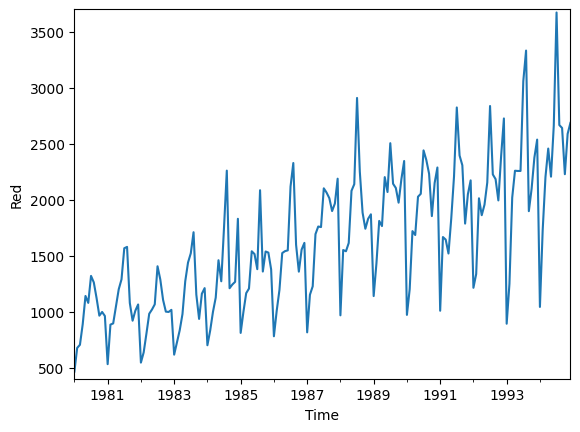

In [ ]:
#plot the time series
import matplotlib.pyplot as plt
ax=redSA_ts.plot()
ax.set_xlabel('Time')
ax.set_ylabel('Red')
ax.set_ylim(400,3700)
plt.show()

In [ ]:
#now we will do a time based data partition to focus on recent data points
#train is older data, test is newer data

nValid = 24 #2 years so 12*2 = past 24 months
nTrain=len(redSA_ts)-nValid #everything minus the past 36 months is training
train_ts=redSA_ts[:nTrain]
valid_ts=redSA_ts[nTrain:]

In [ ]:
train_ts

,Red
Month,
1980-01-01,464
1980-02-01,675
1980-03-01,703
1980-04-01,887
1980-05-01,1139
...,...
1992-08-01,2224
1992-09-01,2182
1992-10-01,1992


In [ ]:
#create regression based model
import statsmodels.formula.api as sm
from statsmodels.tsa import tsatools, stattools

In [ ]:
#create dataframe for regression based models
#add trend for the entire time series (train and test)
#create dummy variable for modeling months
ts_df = tsatools.add_trend(redSA_ts, trend='ct')
ts_df['Month']=ts_df.index.month

In [ ]:
ts_df

,Red,const,trend,Month
Month,,,,
1980-01-01,464,1.0,1.0,1
1980-02-01,675,1.0,2.0,2
1980-03-01,703,1.0,3.0,3
1980-04-01,887,1.0,4.0,4
1980-05-01,1139,1.0,5.0,5
...,...,...,...,...
1994-08-01,2665,1.0,176.0,8
1994-09-01,2639,1.0,177.0,9
1994-10-01,2226,1.0,178.0,10


In [ ]:
#split dataframe
nValid = 24
nTrain=len(ts_df)-nValid
train_df=ts_df[:nTrain]
valid_df=ts_df[nTrain:]

#train first regression model with linear trend
red_lmSA=sm.ols(formula='Red ~ trend', data=train_df).fit()

In [ ]:
#check the model summary for linear trend
red_lmSA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Red   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     180.8
Date:                Mon, 17 Nov 2025   Prob (F-statistic):           9.22e-28
Time:                        22:38:10   Log-Likelihood:                -1143.3
No. Observations:                 156   AIC:                             2291.
Df Residuals:                     154   BIC:                             2297.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    831.8371     59.688     13.936      0.000     713.924     949.750
trend          8.8695      0.660     13.448      0.000       7.567      10.172
==============================================================================
Omnibus:                        1.726   Durbin-Watson:                   1.080
Prob(Omnibus):                  0.422   Jarque-Bera (JB):                1.387
Skew:                          -0.052   Prob(JB):                        0.500
Kurtosis:                       3.450   Cond. No.                         182.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
#now lets check model performance on the validation set
! pip install dmba
from dmba import regressionSummary

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 52.0 MB/s eta 0:00:00
Colab environment detected.


In [ ]:
#lets check the model performance
predict_lm=red_lmSA.predict(valid_df)
regressionSummary(valid_ts,predict_lm)


Regression statistics

                      Mean Error (ME) : -35.9661
       Root Mean Squared Error (RMSE) : 606.8201
            Mean Absolute Error (MAE) : 427.9007
          Mean Percentage Error (MPE) : -12.5160
Mean Absolute Percentage Error (MAPE) : 25.2636


In [ ]:
#create model for seasonality per month
red_lm_season = sm.ols(formula='Red~C(Month)', data=train_df).fit()
red_lm_season.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Red   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     8.406
Date:                Mon, 17 Nov 2025   Prob (F-statistic):           2.57e-11
Time:                        22:38:29   Log-Likelihood:                -1165.2
No. Observations:                 156   AIC:                             2354.
Df Residuals:                     144   BIC:                             2391.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        811.3077    122.433      6.627      0.000     569.310    1053.305
C(Month)[T.2]    271.3846    173.146      1.567      0.119     -70.851     613.620
C(Month)[T.3]    460.1538    173.146      2.658      0.009     117.918     802.390
C(Month)[T.4]    563.0769    173.146      3.252      0.001     220.841     905.313
C(Month)[T.5]    804.6923    173.146      4.647      0.000     462.457    1146.928
C(Month)[T.6]    847.3077    173.146      4.894      0.000     505.072    1189.543
C(Month)[T.7]   1239.4615    173.146      7.158      0.000     897.226    1581.697
C(Month)[T.8]   1182.5385    173.146      6.830      0.000     840.303    1524.774
C(Month)[T.9]    829.3077    173.146      4.790      0.000     487.072    1171.543
C(Month)[T.10]   664.3846    173.146      3.837      0.000     322.149    1006.620
C(Month)[T.11]   808.6154    173.146      4.670      0.000     466.380    1150.851
C(Month)[T.12]   930.4615    173.146      5.374      0.000     588.226    1272.697
==============================================================================
Omnibus:                       39.734   Durbin-Watson:                   0.292
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                7.908
Skew:                           0.025   Prob(JB):                       0.0192
Kurtosis:                       1.898   Cond. No.                         12.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
#check the model score of seasonality model
predict_lm_season=red_lm_season.predict(valid_df)
regressionSummary(valid_ts,predict_lm_season)


Regression statistics

                      Mean Error (ME) : 762.2853
       Root Mean Squared Error (RMSE) : 838.6621
            Mean Absolute Error (MAE) : 762.2853
          Mean Percentage Error (MPE) : 31.4759
Mean Absolute Percentage Error (MAPE) : 31.4759


In [ ]:
#create trend and seasonality
#look at the model summary
modelformula = 'Red ~ trend + np.square(trend)+C(Month)'
red_lm_trendseason = sm.ols(formula=modelformula, data=train_df).fit()
red_lm_trendseason.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Red   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     85.55
Date:                Mon, 17 Nov 2025   Prob (F-statistic):           2.38e-60
Time:                        22:38:29   Log-Likelihood:                -1033.9
No. Observations:                 156   AIC:                             2096.
Df Residuals:                     142   BIC:                             2139.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          177.5683     68.279      2.601      0.010      42.593     312.543
C(Month)[T.2]      262.8345     75.186      3.496      0.001     114.206     411.463
C(Month)[T.3]      443.0593     75.188      5.893      0.000     294.426     591.692
C(Month)[T.4]      537.4435     75.192      7.148      0.000     388.803     686.084
C(Month)[T.5]      770.5258     75.198     10.247      0.000     621.874     919.178
C(Month)[T.6]      804.6137     75.205     10.699      0.000     655.948     953.279
C(Month)[T.7]     1188.2457     75.213     15.798      0.000    1039.563    1336.928
C(Month)[T.8]     1122.8065     75.223     14.926      0.000     974.104    1271.509
C(Month)[T.9]      761.0652     75.235     10.116      0.000     612.340     909.790
C(Month)[T.10]     587.6373     75.248      7.809      0.000     438.886     736.388
C(Month)[T.11]     723.3688     75.263      9.611      0.000     574.589     872.149
C(Month)[T.12]     836.7215     75.279     11.115      0.000     687.909     985.534
trend                8.9661      1.372      6.536      0.000       6.254      11.678
np.square(trend)    -0.0028      0.008     -0.334      0.739      -0.020       0.014
==============================================================================
Omnibus:                        3.338   Durbin-Watson:                   1.540
Prob(Omnibus):                  0.188   Jarque-Bera (JB):                3.081
Skew:                           0.204   Prob(JB):                        0.214
Kurtosis:                       3.555   Cond. No.                     1.37e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.37e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
#trend and seasonality score
predict_lm_trendseason=red_lm_trendseason.predict(valid_df)
regressionSummary(valid_ts,predict_lm_trendseason)


Regression statistics

                      Mean Error (ME) : 12.6374
       Root Mean Squared Error (RMSE) : 339.1057
            Mean Absolute Error (MAE) : 259.7121
          Mean Percentage Error (MPE) : -4.8302
Mean Absolute Percentage Error (MAPE) : 14.1887


In [ ]:
#create a simple exponential smoothing model
from statsmodels.tsa.api import SimpleExpSmoothing
SES = SimpleExpSmoothing(train_ts, initialization_method='estimated').fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
SES.model.params

{'smoothing_level': np.float64(0.6493087598800544),
 'smoothing_trend': np.float64(nan),
 'smoothing_seasonal': np.float64(nan),
 'damping_trend': nan,
 'initial_level': np.float64(553.1934333963179),
 'initial_trend': np.float64(nan),
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [ ]:
alphas = [0.1, 0.3, 0.5, 0.7, 0.9]

print("Testing different alpha values for Simple Exponential Smoothing:")
for alpha in alphas:
    print(f"\n--- Alpha = {alpha} ---")
    SES_fixed_alpha = SimpleExpSmoothing(train_ts, initialization_method=None).fit(smoothing_level=alpha)
    predict_SES_fixed_alpha = SES_fixed_alpha.forecast(len(valid_ts))
    print(f"SES model parameters with alpha={alpha}:\n{SES_fixed_alpha.model.params}")
    print("Performance with fixed alpha:")
    regressionSummary(valid_ts, predict_SES_fixed_alpha)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Testing different alpha values for Simple Exponential Smoothing:

--- Alpha = 0.1 ---
SES model parameters with alpha=0.1:
{'smoothing_level': np.float64(0.1), 'smoothing_trend': np.float64(nan), 'smoothing_seasonal': np.float64(nan), 'damping_trend': nan, 'initial_level': np.float64(464.0), 'initial_trend': np.float64(nan), 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}
Performance with fixed alpha:

Regression statistics

                      Mean Error (ME) : 145.3113
       Root Mean Squared Error (RMSE) : 646.4256
            Mean Absolute Error (MAE) : 486.9318
          Mean Percentage Error (MPE) : -4.2455
Mean Absolute Percentage Error (MAPE) : 26.1533

--- Alpha = 0.3 ---
SES model parameters with alpha=0.3:
{'smoothing_level': np.float64(0.3), 'smoothing_trend': np.float64(nan), 'smoothing_seasonal': np.float64(nan), 'damping_trend': nan, 'initial_level': np.float64(464.0), 'initial_trend': np.float64(nan), 'initial_se

/usr/local/lib/python3.12/dist-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warnin